# Capstone 1
An exploration of US Census Bureau data available through the Current Population Survey (CPS), using a single month of the Basic Monthly CPS.

---

In [1]:
import json
import pyspark as ps
from pyspark.sql.types import *
from pyspark.sql.functions import udf, col, when, stddev, mean
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import re
import time
%matplotlib inline

%load_ext autoreload
%autoreload 2
from src.datadict import dd_to_structure, ageGrouping, hh_income
from src.quick_look import ql, quick_plot
from src.script import *

plt.rcParams['figure.figsize'] = [30, 15]
plt.style.use('bmh')

In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("Capstone 1") \
            .config("spark.sql.caseSensitive", "true")\
            .getOrCreate()
sc = spark.sparkContext

Initial exploration of a CPS dataset requires some formatting. The information needed to understand the formatting of the dataset is found in a data dictionary, with an update provided as the data format changes. 

For 2021, the dataset is located [here](https://www.census.gov/data/datasets/time-series/demo/cps/cps-basic.html). The data dictionary is [here](https://www2.census.gov/programs-surveys/cps/datasets/2021/basic/2021_Basic_CPS_Public_Use_Record_Layout_plus_IO_Code_list.txt), and is downloaded to:
`data/2021_Basic_CPS_Public_Use_Record_Layout_plus_IO_Code_list.txt`

A helper function will decompose the data dictionary into needed information for reformating the file into a usable form. 

In [3]:
headers2, locations2, sizes2, structure2 = dd_to_structure('data/2021_Basic_CPS_Public_Use_Record_Layout_plus_IO_Code_list.txt')

The file I will explore is the Basic Monthly CPS file most recently published at the time of this project. The April 2021 data is [here](https://www2.census.gov/programs-surveys/cps/datasets/2021/basic/apr21pub.dat.gz) and is downloaded and unzipped to:
`data/apr21pub.dat`

The file is read into a temporary Spark dataframe.

In [4]:
tmp_df = spark.read.text('data/apr21pub.dat')

Using the `structure2` string produced by the helper function above, a formatted dataframe is produced to allow exploration of the data. 

In [5]:
apr21_df = tmp_df.select(tmp_df.value.substr( 1, 15).alias('HRHHID'), tmp_df.value.substr(16,  2).alias('HRMONTH'), tmp_df.value.substr(18,  4).alias('HRYEAR4'), tmp_df.value.substr(22,  2).alias('HURESPLI'), tmp_df.value.substr(24,  3).alias('HUFINAL'), tmp_df.value.substr(27,  2).alias('FILLER27'), tmp_df.value.substr(29,  2).alias('HETENURE'), tmp_df.value.substr(31,  2).alias('HEHOUSUT'), tmp_df.value.substr(33,  2).alias('HETELHHD'), tmp_df.value.substr(35,  2).alias('HETELAVL'), tmp_df.value.substr(37,  2).alias('HEPHONEO'), tmp_df.value.substr(39,  2).alias('HEFAMINC'), tmp_df.value.substr(41,  2).alias('HUTYPEA'), tmp_df.value.substr(43,  2).alias('HUTYPB'), tmp_df.value.substr(45,  2).alias('HUTYPC'), tmp_df.value.substr(47, 10).alias('HWHHWGT'), tmp_df.value.substr(57,  2).alias('HRINTSTA'), tmp_df.value.substr(59,  2).alias('HRNUMHOU'), tmp_df.value.substr(61,  2).alias('HRHTYPE'), tmp_df.value.substr(63,  2).alias('HRMIS'), tmp_df.value.substr(65,  2).alias('HUINTTYP'), tmp_df.value.substr(67,  2).alias('HUPRSCNT'), tmp_df.value.substr(69,  2).alias('HRLONGLK'), tmp_df.value.substr(71,  5).alias('HRHHID2'), tmp_df.value.substr(76,  2).alias('HWHHWTLN'), tmp_df.value.substr(78,  1).alias('FILLER78'), tmp_df.value.substr(79,  2).alias('HUBUS'), tmp_df.value.substr(81,  2).alias('HUBUSL1'), tmp_df.value.substr(83,  2).alias('HUBUSL2'), tmp_df.value.substr(85,  2).alias('HUBUSL3'), tmp_df.value.substr(87,  2).alias('HUBUSL4'), tmp_df.value.substr(89,  2).alias('GEREG'), tmp_df.value.substr(91,  1).alias('GEDIV'), tmp_df.value.substr(92,  1).alias('FILLER92'), tmp_df.value.substr(93,  2).alias('GESTFIPS'), tmp_df.value.substr(95,  1).alias('FILLER95'), tmp_df.value.substr(96,  5).alias('GTCBSA'), tmp_df.value.substr(101,  3).alias('GTCO'), tmp_df.value.substr(104,  1).alias('GTCBSAST'), tmp_df.value.substr(105,  1).alias('GTMETSTA'), tmp_df.value.substr(106,  1).alias('GTINDVPC'), tmp_df.value.substr(107,  1).alias('GTCBSASZ'), tmp_df.value.substr(108,  3).alias('GTCSA'), tmp_df.value.substr(111,  3).alias('FILLER111'), tmp_df.value.substr(114,  2).alias('FILLER114'), tmp_df.value.substr(118,  2).alias('PERRP'), tmp_df.value.substr(120,  2).alias('FILLER120'), tmp_df.value.substr(122,  2).alias('PRTAGE'), tmp_df.value.substr(124,  1).alias('PRTFAGE'), tmp_df.value.substr(125,  2).alias('PEMARITL'), tmp_df.value.substr(127,  2).alias('PESPOUSE'), tmp_df.value.substr(129,  2).alias('PESEX'), tmp_df.value.substr(131,  2).alias('PEAFEVER'), tmp_df.value.substr(133,  2).alias('FILLER133'), tmp_df.value.substr(135,  2).alias('PEAFNOW'), tmp_df.value.substr(137,  2).alias('PEEDUCA'), tmp_df.value.substr(139,  2).alias('PTDTRACE'), tmp_df.value.substr(141,  2).alias('PRDTHSP'), tmp_df.value.substr(143,  2).alias('PUCHINHH'), tmp_df.value.substr(145,  2).alias('FILLER145'), tmp_df.value.substr(147,  2).alias('PULINENO'), tmp_df.value.substr(149,  2).alias('FILLER149'), tmp_df.value.substr(151,  2).alias('PRFAMNUM'), tmp_df.value.substr(153,  2).alias('PRFAMREL'), tmp_df.value.substr(155,  2).alias('PRFAMTYP'), tmp_df.value.substr(157,  2).alias('PEHSPNON'), tmp_df.value.substr(159,  2).alias('PRMARSTA'), tmp_df.value.substr(161,  2).alias('PRPERTYP'), tmp_df.value.substr(163,  3).alias('PENATVTY'), tmp_df.value.substr(166,  3).alias('PEMNTVTY'), tmp_df.value.substr(169,  3).alias('PEFNTVTY'), tmp_df.value.substr(172,  2).alias('PRCITSHP'), tmp_df.value.substr(174,  2).alias('PRCITFLG'), tmp_df.value.substr(176,  2).alias('PRINUSYR'), tmp_df.value.substr(178,  2).alias('PUSLFPRX'), tmp_df.value.substr(180,  2).alias('PEMLR'), tmp_df.value.substr(182,  2).alias('PUWK'), tmp_df.value.substr(184,  2).alias('PUBUS1'), tmp_df.value.substr(186,  2).alias('PUBUS2OT'), tmp_df.value.substr(188,  2).alias('PUBUSCK1'), tmp_df.value.substr(190,  2).alias('PUBUSCK2'), tmp_df.value.substr(192,  2).alias('PUBUSCK3'), tmp_df.value.substr(194,  2).alias('PUBUSCK4'), tmp_df.value.substr(196,  2).alias('PURETOT'), tmp_df.value.substr(198,  2).alias('PUDIS'), tmp_df.value.substr(200,  2).alias('PERET1'), tmp_df.value.substr(202,  2).alias('PUDIS1'), tmp_df.value.substr(204,  2).alias('PUDIS2'), tmp_df.value.substr(206,  2).alias('PUABSOT'), tmp_df.value.substr(208,  2).alias('PULAY'), tmp_df.value.substr(210,  2).alias('PEABSRSN'), tmp_df.value.substr(212,  2).alias('PEABSPDO'), tmp_df.value.substr(214,  2).alias('PEMJOT'), tmp_df.value.substr(216,  2).alias('PEMJNUM'), tmp_df.value.substr(218,  2).alias('PEHRUSL1'), tmp_df.value.substr(220,  2).alias('PEHRUSL2'), tmp_df.value.substr(222,  2).alias('PEHRFTPT'), tmp_df.value.substr(224,  3).alias('PEHRUSLT'), tmp_df.value.substr(227,  2).alias('PEHRWANT'), tmp_df.value.substr(229,  2).alias('PEHRRSN1'), tmp_df.value.substr(231,  2).alias('PEHRRSN2'), tmp_df.value.substr(233,  2).alias('PEHRRSN3'), tmp_df.value.substr(235,  2).alias('PUHROFF1'), tmp_df.value.substr(237,  2).alias('PUHROFF2'), tmp_df.value.substr(239,  2).alias('PUHROT1'), tmp_df.value.substr(241,  2).alias('PUHROT2'), tmp_df.value.substr(243,  2).alias('PEHRACT1'), tmp_df.value.substr(245,  2).alias('PEHRACT2'), tmp_df.value.substr(247,  3).alias('PEHRACTT'), tmp_df.value.substr(250,  2).alias('PEHRAVL'), tmp_df.value.substr(252,  5).alias('FILLER252'), tmp_df.value.substr(257,  2).alias('PUHRCK1'), tmp_df.value.substr(259,  2).alias('PUHRCK2'), tmp_df.value.substr(261,  2).alias('PUHRCK3'), tmp_df.value.substr(263,  2).alias('PUHRCK4'), tmp_df.value.substr(265,  2).alias('PUHRCK5'), tmp_df.value.substr(267,  2).alias('PUHRCK6'), tmp_df.value.substr(269,  2).alias('PUHRCK7'), tmp_df.value.substr(271,  2).alias('PUHRCK12'), tmp_df.value.substr(273,  2).alias('PULAYDT'), tmp_df.value.substr(275,  2).alias('PULAY6M'), tmp_df.value.substr(277,  2).alias('PELAYAVL'), tmp_df.value.substr(279,  2).alias('PULAYAVR'), tmp_df.value.substr(281,  2).alias('PELAYLK'), tmp_df.value.substr(283,  3).alias('PELAYDUR'), tmp_df.value.substr(286,  2).alias('PELAYFTO'), tmp_df.value.substr(288,  2).alias('PULAYCK1'), tmp_df.value.substr(290,  2).alias('PULAYCK2'), tmp_df.value.substr(292,  2).alias('PULAYCK3'), tmp_df.value.substr(294,  2).alias('PULK'), tmp_df.value.substr(296,  2).alias('PELKM1'), tmp_df.value.substr(298,  2).alias('PULKM2'), tmp_df.value.substr(300,  2).alias('PULKM3'), tmp_df.value.substr(302,  2).alias('PULKM4'), tmp_df.value.substr(304,  2).alias('PULKM5'), tmp_df.value.substr(306,  2).alias('PULKM6'), tmp_df.value.substr(308,  2).alias('PULKDK1'), tmp_df.value.substr(310,  2).alias('PULKDK2'), tmp_df.value.substr(312,  2).alias('PULKDK3'), tmp_df.value.substr(314,  2).alias('PULKDK4'), tmp_df.value.substr(316,  2).alias('PULKDK5'), tmp_df.value.substr(318,  2).alias('PULKDK6'), tmp_df.value.substr(320,  2).alias('PULKPS1'), tmp_df.value.substr(322,  2).alias('PULKPS2'), tmp_df.value.substr(324,  2).alias('PULKPS3'), tmp_df.value.substr(326,  2).alias('PULKPS4'), tmp_df.value.substr(328,  2).alias('PULKPS5'), tmp_df.value.substr(330,  2).alias('PULKPS6'), tmp_df.value.substr(332,  2).alias('PELKAVL'), tmp_df.value.substr(334,  2).alias('PULKAVR'), tmp_df.value.substr(336,  2).alias('PELKLL1O'), tmp_df.value.substr(338,  2).alias('PELKLL2O'), tmp_df.value.substr(340,  2).alias('PELKLWO'), tmp_df.value.substr(342,  3).alias('PELKDUR'), tmp_df.value.substr(345,  2).alias('PELKFTO'), tmp_df.value.substr(347,  2).alias('PEDWWNTO'), tmp_df.value.substr(349,  2).alias('PEDWRSN'), tmp_df.value.substr(351,  2).alias('PEDWLKO'), tmp_df.value.substr(353,  2).alias('PEDWWK'), tmp_df.value.substr(355,  2).alias('PEDW4WK'), tmp_df.value.substr(357,  2).alias('PEDWLKWK'), tmp_df.value.substr(359,  2).alias('PEDWAVL'), tmp_df.value.substr(361,  2).alias('PEDWAVR'), tmp_df.value.substr(363,  2).alias('PUDWCK1'), tmp_df.value.substr(365,  2).alias('PUDWCK2'), tmp_df.value.substr(367,  2).alias('PUDWCK3'), tmp_df.value.substr(369,  2).alias('PUDWCK4'), tmp_df.value.substr(371,  2).alias('PUDWCK5'), tmp_df.value.substr(373,  2).alias('PEJHWKO'), tmp_df.value.substr(375,  2).alias('PUJHDP1O'), tmp_df.value.substr(377,  2).alias('PEJHRSN'), tmp_df.value.substr(379,  2).alias('PEJHWANT'), tmp_df.value.substr(381,  2).alias('PUJHCK1'), tmp_df.value.substr(383,  2).alias('PUJHCK2'), tmp_df.value.substr(385,  2).alias('PRABSREA'), tmp_df.value.substr(387,  2).alias('PRCIVLF'), tmp_df.value.substr(389,  2).alias('PRDISC'), tmp_df.value.substr(391,  2).alias('PREMPHRS'), tmp_df.value.substr(393,  2).alias('PREMPNOT'), tmp_df.value.substr(395,  2).alias('PREXPLF'), tmp_df.value.substr(397,  2).alias('PRFTLF'), tmp_df.value.substr(399,  2).alias('PRHRUSL'), tmp_df.value.substr(401,  2).alias('PRJOBSEA'), tmp_df.value.substr(403,  2).alias('PRPTHRS'), tmp_df.value.substr(405,  2).alias('PRPTREA'), tmp_df.value.substr(407,  3).alias('PRUNEDUR'), tmp_df.value.substr(410,  2).alias('FILLER410'), tmp_df.value.substr(412,  2).alias('PRUNTYPE'), tmp_df.value.substr(414,  2).alias('PRWKSCH'), tmp_df.value.substr(416,  2).alias('PRWKSTAT'), tmp_df.value.substr(418,  2).alias('PRWNTJOB'), tmp_df.value.substr(420,  2).alias('PUJHCK3'), tmp_df.value.substr(422,  2).alias('PUJHCK4'), tmp_df.value.substr(424,  2).alias('PUJHCK5'), tmp_df.value.substr(426,  2).alias('PUIODP1'), tmp_df.value.substr(428,  2).alias('PUIODP2'), tmp_df.value.substr(430,  2).alias('PUIODP3'), tmp_df.value.substr(432,  2).alias('PEIO1COW'), tmp_df.value.substr(434,  2).alias('PUIO1MFG'), tmp_df.value.substr(436,  6).alias('PADDING436'), tmp_df.value.substr(442,  2).alias('PEIO2COW'), tmp_df.value.substr(444,  2).alias('PUIO2MFG'), tmp_df.value.substr(446,  6).alias('PADDING446'), tmp_df.value.substr(452,  2).alias('PUIOCK1'), tmp_df.value.substr(454,  2).alias('PUIOCK2'), tmp_df.value.substr(456,  2).alias('PUIOCK3'), tmp_df.value.substr(458,  2).alias('PRIOELG'), tmp_df.value.substr(460,  2).alias('PRAGNA'), tmp_df.value.substr(462,  2).alias('PRCOW1'), tmp_df.value.substr(464,  2).alias('PRCOW2'), tmp_df.value.substr(466,  2).alias('PRCOWPG'), tmp_df.value.substr(468,  2).alias('PRDTCOW1'), tmp_df.value.substr(470,  2).alias('PRDTCOW2'), tmp_df.value.substr(472,  2).alias('PRDTIND1'), tmp_df.value.substr(474,  2).alias('PRDTIND2'), tmp_df.value.substr(476,  2).alias('PRDTOCC1'), tmp_df.value.substr(478,  2).alias('PRDTOCC2'), tmp_df.value.substr(480,  2).alias('PREMP'), tmp_df.value.substr(482,  2).alias('PRMJIND1'), tmp_df.value.substr(484,  2).alias('PRMJIND2'), tmp_df.value.substr(486,  2).alias('PRMJOCC1'), tmp_df.value.substr(488,  2).alias('PRMJOCC2'), tmp_df.value.substr(490,  2).alias('PRMJOCGR'), tmp_df.value.substr(492,  2).alias('PRNAGPWS'), tmp_df.value.substr(494,  2).alias('PRNAGWS'), tmp_df.value.substr(496,  2).alias('PRSJMS'), tmp_df.value.substr(498,  2).alias('PRERELG'), tmp_df.value.substr(500,  2).alias('PEERNUOT'), tmp_df.value.substr(502,  2).alias('PEERNPER'), tmp_df.value.substr(504,  2).alias('PEERNRT'), tmp_df.value.substr(506,  2).alias('PEERNHRY'), tmp_df.value.substr(508,  4).alias('PTERNH1C'), tmp_df.value.substr(512,  4).alias('PTERNH2'), tmp_df.value.substr(516,  4).alias('PTERNH1O'), tmp_df.value.substr(520,  4).alias('PTERNHLY'), tmp_df.value.substr(524,  1).alias('PTHR'), tmp_df.value.substr(525,  2).alias('PEERNHRO'), tmp_df.value.substr(527,  8).alias('PTERNWA'), tmp_df.value.substr(535,  1).alias('PTWK'), tmp_df.value.substr(536,  4).alias('FILLER536'), tmp_df.value.substr(540,  8).alias('PTERN'), tmp_df.value.substr(548,  8).alias('PTERN2'), tmp_df.value.substr(556,  1).alias('PTOT'), tmp_df.value.substr(557,  2).alias('FILLER557'), tmp_df.value.substr(559,  2).alias('PEERNWKP'), tmp_df.value.substr(561,  2).alias('PEERNLAB'), tmp_df.value.substr(563,  2).alias('PEERNCOV'), tmp_df.value.substr(565,  2).alias('PENLFJH'), tmp_df.value.substr(567,  2).alias('PENLFRET'), tmp_df.value.substr(569,  2).alias('PENLFACT'), tmp_df.value.substr(571,  2).alias('PUNLFCK1'), tmp_df.value.substr(573,  2).alias('PUNLFCK2'), tmp_df.value.substr(575,  2).alias('PESCHENR'), tmp_df.value.substr(577,  2).alias('PESCHFT'), tmp_df.value.substr(579,  2).alias('PESCHLVL'), tmp_df.value.substr(581,  2).alias('PRNLFSCH'), tmp_df.value.substr(583, 10).alias('PWFMWGT'), tmp_df.value.substr(593, 10).alias('PWLGWGT'), tmp_df.value.substr(603, 10).alias('PWORWGT'), tmp_df.value.substr(613, 10).alias('PWSSWGT'), tmp_df.value.substr(623, 10).alias('PWVETWGT'), tmp_df.value.substr(633,  2).alias('PRCHLD'), tmp_df.value.substr(635,  2).alias('PRNMCHLD'), tmp_df.value.substr(637,  2).alias('PXPDEMP1'), tmp_df.value.substr(639,  2).alias('PRWERNAL'), tmp_df.value.substr(641,  2).alias('PRHERNAL'), tmp_df.value.substr(643,  2).alias('HXTENURE'), tmp_df.value.substr(645,  2).alias('HXHOUSUT'), tmp_df.value.substr(647,  2).alias('HXTELHHD'), tmp_df.value.substr(649,  2).alias('HXTELAVL'), tmp_df.value.substr(651,  2).alias('HXPHONEO'), tmp_df.value.substr(653,  2).alias('PXINUSYR'), tmp_df.value.substr(655,  2).alias('PXRRP'), tmp_df.value.substr(657,  2).alias('PXPARENT'), tmp_df.value.substr(659,  2).alias('PXAGE'), tmp_df.value.substr(661,  2).alias('PXMARITL'), tmp_df.value.substr(663,  2).alias('PXSPOUSE'), tmp_df.value.substr(665,  2).alias('PXSEX'), tmp_df.value.substr(667,  2).alias('PXAFWHN1'), tmp_df.value.substr(669,  2).alias('PXAFNOW'), tmp_df.value.substr(671,  2).alias('PXEDUCA'), tmp_df.value.substr(673,  2).alias('PXRACE1'), tmp_df.value.substr(675,  2).alias('PXNATVTY'), tmp_df.value.substr(677,  2).alias('PXMNTVTY'), tmp_df.value.substr(679,  2).alias('PXFNTVTY'), tmp_df.value.substr(681,  2).alias('PXNMEMP1'), tmp_df.value.substr(683,  2).alias('PXHSPNON'), tmp_df.value.substr(685,  2).alias('PXMLR'), tmp_df.value.substr(687,  2).alias('PXRET1'), tmp_df.value.substr(689,  2).alias('PXABSRSN'), tmp_df.value.substr(691,  2).alias('PXABSPDO'), tmp_df.value.substr(693,  2).alias('PXMJOT'), tmp_df.value.substr(695,  2).alias('PXMJNUM'), tmp_df.value.substr(697,  2).alias('PXHRUSL1'), tmp_df.value.substr(699,  2).alias('PXHRUSL2'), tmp_df.value.substr(701,  2).alias('PXHRFTPT'), tmp_df.value.substr(703,  2).alias('PXHRUSLT'), tmp_df.value.substr(705,  2).alias('PXHRWANT'), tmp_df.value.substr(707,  2).alias('PXHRRSN1'), tmp_df.value.substr(709,  2).alias('PXHRRSN2'), tmp_df.value.substr(711,  2).alias('PXHRACT1'), tmp_df.value.substr(713,  2).alias('PXHRACT2'), tmp_df.value.substr(715,  2).alias('PXHRACTT'), tmp_df.value.substr(717,  2).alias('PXHRRSN3'), tmp_df.value.substr(719,  2).alias('PXHRAVL'), tmp_df.value.substr(721,  2).alias('PXLAYAVL'), tmp_df.value.substr(723,  2).alias('PXLAYLK'), tmp_df.value.substr(725,  2).alias('PXLAYDUR'), tmp_df.value.substr(727,  2).alias('PXLAYFTO'), tmp_df.value.substr(729,  2).alias('PXLKM1'), tmp_df.value.substr(731,  2).alias('PXLKAVL'), tmp_df.value.substr(733,  2).alias('PXLKLL1O'), tmp_df.value.substr(735,  2).alias('PXLKLL2O'), tmp_df.value.substr(737,  2).alias('PXLKLWO'), tmp_df.value.substr(739,  2).alias('PXLKDUR'), tmp_df.value.substr(741,  2).alias('PXLKFTO'), tmp_df.value.substr(743,  2).alias('PXDWWNTO'), tmp_df.value.substr(745,  2).alias('PXDWRSN'), tmp_df.value.substr(747,  2).alias('PXDWLKO'), tmp_df.value.substr(749,  2).alias('PXDWWK'), tmp_df.value.substr(751,  2).alias('PXDW4WK'), tmp_df.value.substr(753,  2).alias('PXDWLKWK'), tmp_df.value.substr(755,  2).alias('PXDWAVL'), tmp_df.value.substr(757,  2).alias('PXDWAVR'), tmp_df.value.substr(759,  2).alias('PXJHWKO'), tmp_df.value.substr(761,  2).alias('PXJHRSN'), tmp_df.value.substr(763,  2).alias('PXJHWANT'), tmp_df.value.substr(765,  2).alias('PXIO1COW'), tmp_df.value.substr(767,  2).alias('PXIO1ICD'), tmp_df.value.substr(769,  2).alias('PXIO1OCD'), tmp_df.value.substr(771,  2).alias('PXIO2COW'), tmp_df.value.substr(773,  2).alias('PXIO2ICD'), tmp_df.value.substr(775,  2).alias('PXIO2OCD'), tmp_df.value.substr(777,  2).alias('PXERNUOT'), tmp_df.value.substr(779,  2).alias('PXERNPER'), tmp_df.value.substr(781,  2).alias('PXERNH1O'), tmp_df.value.substr(783,  2).alias('PXERNHRO'), tmp_df.value.substr(785,  2).alias('PXERN'), tmp_df.value.substr(787,  2).alias('PXPDEMP2'), tmp_df.value.substr(789,  2).alias('PXNMEMP2'), tmp_df.value.substr(791,  2).alias('PXERNWKP'), tmp_df.value.substr(793,  2).alias('PXERNRT'), tmp_df.value.substr(795,  2).alias('PXERNHRY'), tmp_df.value.substr(797,  2).alias('PXERNH2'), tmp_df.value.substr(799,  2).alias('PXERNLAB'), tmp_df.value.substr(801,  2).alias('PXERNCOV'), tmp_df.value.substr(803,  2).alias('PXNLFJH'), tmp_df.value.substr(805,  2).alias('PXNLFRET'), tmp_df.value.substr(807,  2).alias('PXNLFACT'), tmp_df.value.substr(809,  2).alias('PXSCHENR'), tmp_df.value.substr(811,  2).alias('PXSCHFT'), tmp_df.value.substr(813,  2).alias('PXSCHLVL'), tmp_df.value.substr(815,  5).alias('QSTNUM'), tmp_df.value.substr(820,  2).alias('OCCURNUM'), tmp_df.value.substr(822,  2).alias('PEDIPGED'), tmp_df.value.substr(824,  2).alias('PEHGCOMP'), tmp_df.value.substr(826,  2).alias('PECYC'), tmp_df.value.substr(828,  6).alias('PADDING828'), tmp_df.value.substr(834,  2).alias('PXDIPGED'), tmp_df.value.substr(836,  2).alias('PXHGCOMP'), tmp_df.value.substr(838,  2).alias('PXCYC'), tmp_df.value.substr(840,  6).alias('FILLER840'), tmp_df.value.substr(846, 10).alias('PWCMPWGT'), tmp_df.value.substr(856,  4).alias('PEIO1ICD'), tmp_df.value.substr(860,  4).alias('PTIO1OCD'), tmp_df.value.substr(864,  4).alias('PEIO2ICD'), tmp_df.value.substr(868,  4).alias('PTIO2OCD'), tmp_df.value.substr(872,  2).alias('PRIMIND1'), tmp_df.value.substr(874,  2).alias('PRIMIND2'), tmp_df.value.substr(876,  2).alias('PEAFWHN1'), tmp_df.value.substr(878,  2).alias('PEAFWHN2'), tmp_df.value.substr(880,  2).alias('PEAFWHN3'), tmp_df.value.substr(882,  2).alias('PEAFWHN4'), tmp_df.value.substr(884,  2).alias('PXAFEVER'), tmp_df.value.substr(886,  2).alias('PEPAR2'), tmp_df.value.substr(888,  2).alias('PEPAR1'), tmp_df.value.substr(890,  2).alias('PEPAR2TYP'), tmp_df.value.substr(892,  2).alias('PEPAR1TYP'), tmp_df.value.substr(894,  2).alias('PECOHAB'), tmp_df.value.substr(896,  2).alias('PXPAR2'), tmp_df.value.substr(898,  2).alias('PXPAR1'), tmp_df.value.substr(900,  2).alias('PXPAR2TYP'), tmp_df.value.substr(902,  2).alias('PXPAR1TYP'), tmp_df.value.substr(904,  2).alias('PXCOHAB'), tmp_df.value.substr(906,  2).alias('PEDISEAR'), tmp_df.value.substr(908,  2).alias('PEDISEYE'), tmp_df.value.substr(910,  2).alias('PEDISREM'), tmp_df.value.substr(912,  2).alias('PEDISPHY'), tmp_df.value.substr(914,  2).alias('PEDISDRS'), tmp_df.value.substr(916,  2).alias('PEDISOUT'), tmp_df.value.substr(918,  2).alias('PRDISFLG'), tmp_df.value.substr(920,  2).alias('PXDISEAR'), tmp_df.value.substr(922,  2).alias('PXDISEYE'), tmp_df.value.substr(924,  2).alias('PXDISREM'), tmp_df.value.substr(926,  2).alias('PXDISPHY'), tmp_df.value.substr(928,  2).alias('PXDISDRS'), tmp_df.value.substr(930,  2).alias('PXDISOUT'), tmp_df.value.substr(932,  2).alias('HXFAMINC'), tmp_df.value.substr(934,  2).alias('PRDASIAN'), tmp_df.value.substr(936,  2).alias('PEPDEMP1'), tmp_df.value.substr(938,  2).alias('PTNMEMP1'), tmp_df.value.substr(940,  2).alias('PEPDEMP2'), tmp_df.value.substr(942,  2).alias('PTNMEMP2'), tmp_df.value.substr(944,  2).alias('PECERT1'), tmp_df.value.substr(946,  2).alias('PECERT2'), tmp_df.value.substr(948,  2).alias('PECERT3'), tmp_df.value.substr(950,  2).alias('PXCERT1'), tmp_df.value.substr(952,  2).alias('PXCERT2'), tmp_df.value.substr(954,  2).alias('PXCERT3'), tmp_df.value.substr(956, 45).alias('FILLER956'))

In [6]:
age_udf = udf(ageGrouping, StringType())

apr21_df = apr21_df.withColumn("AgeGroup", 
    age_udf(apr21_df['PRTAGE'])
  ).withColumn("AgeGroup",when(col("PRPERTYP") == 1, '  child').otherwise(col("AgeGroup")))

hh_udf = udf(hh_income, IntegerType())

apr21_df = apr21_df.withColumn("HHincome", hh_udf(apr21_df['HEFAMINC']))

A temp view is created for the dataframe to permit applying SQL functions. 

In [7]:
apr21_df.createOrReplaceTempView('apr21_df')

In [8]:
apr21_df.count()

133449

# Veterans status

In [9]:
query = '''SELECT
    (CASE WHEN (PEAFEVER = 1) THEN 'Veterans' ELSE 'Civilians' END) AS PEAFEVER ,
    COUNT(*) as Pop,
    SUM(CASE WHEN (PEMLR = 1 OR PEMLR = 2) THEN 1 ELSE 0 END) AS WORKING,
    round(100 * SUM(CASE WHEN (PEMLR = 1 OR PEMLR = 2) THEN 1 ELSE 0 END) / COUNT(*), 1) as WORKING_pct,
    SUM(CASE WHEN (PEMLR > 2) THEN 1 ELSE 0 END) AS NOT_WORKING,
    round(100 * SUM(CASE WHEN (PEMLR > 2) THEN 1 ELSE 0 END) / COUNT(*), 1) as NOT_WORKING_pct
FROM
    apr21_df
WHERE 
    PEAFEVER >= 0
GROUP BY
    PEAFEVER
ORDER BY 
    PEAFEVER
'''

wrk_pdf = spark.sql(query).toPandas()
wrk_pdf.rename(columns = {'PEAFEVER': 'Vet Status', 'Pop':'Population', 'WORKING': 'Working', 'WORKING_pct': 'Working (%)', 'NOT_WORKING': 'Not Working', 'NOT_WORKING_pct': 'Not Working (%)', 'UNEMPLOYED': 'Unemployed', 'UNEMPLOYED_pct': 'Unemployed (%)', 'NILF_pct': 'NILF (%)' }, inplace = True)

wrk_pdf

,Vet Status,Population,Working,Working (%),Not Working,Not Working (%)
0,Veterans,6625,2710,40.9,3915,59.1
1,Civilians,81459,47933,58.8,33526,41.2


# Hypothesis: 
## the proportion of the population of employed veterans is equal to the proportion of the population of employed civilians (non-veterans).
Null hypothesis: $H_0: p_{vet} - p_{civ} = 0$ 


Alternative hypothesis:
$H_a: p_{vets} - p_{civ} \neq 0$

Rejection region for approximate level $\alpha$ test: 
$z \leq -z_\alpha \:$ or $\:z \geq z_\alpha$

Normal approximation of binomial distributions.

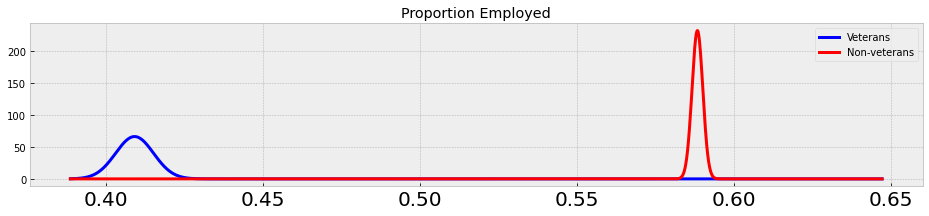

In [51]:
null_hypothesis = r'$H_0: p_{vet} - p_{civ} = 0$'

m = wrk_pdf[wrk_pdf['Vet Status'] == 'Veterans']['Population'].values[0]
n = wrk_pdf[wrk_pdf['Vet Status'] == 'Civilians']['Population'].values[0]
X = wrk_pdf[wrk_pdf['Vet Status'] == 'Veterans']['Working'].values[0]
Y = wrk_pdf[wrk_pdf['Vet Status'] == 'Civilians']['Working'].values[0]

title = 'Proportion Employed'
savetofile = 'wrk_proportions' 
plot_workforce_proportions(m, X, n, Y, title, savetofile)

('diff in proportion: -0.1794, total proportion: 0.575, variance: 0.00004, p_value: 0.000, z_alpha: -0.012',
 'Proportions - Sample 1: 0.409; Sample 2: 0.588. Difference: -0.179',
 'The p-value is: 0.000, and the rejection thresholds are -0.012 and 0.012',
 "For 'H_0 : p_1 = p_2', the tests fails to reject the null hypothesis")

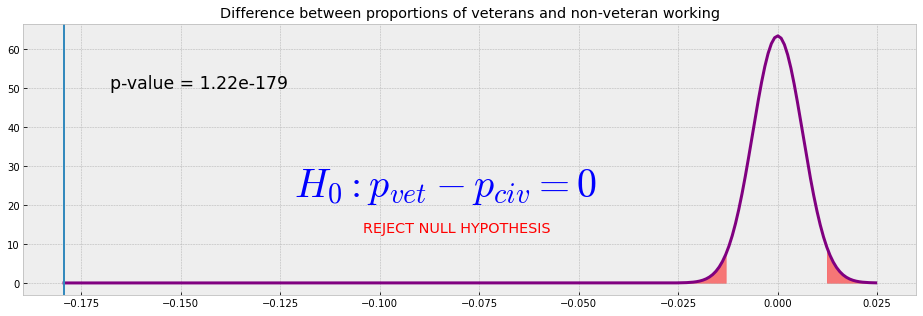

In [52]:
title = 'Difference between proportions of veterans and non-veteran working'
savetofile = 'wrk_diff' 
plot_test_results(m, X, n, Y, title, savetofile, null_hypothesis)

test_report(m, X, n, Y)

## Correction for NILF
However, the above analysis failed to recognize that "Not Working" != "Unemployed". Looking at the data more closely, respondents can also be categorized as "Not in Labor Force", which would include retirees and students. 

In [53]:
query = '''SELECT
    (CASE WHEN (PEAFEVER = 1) THEN 'Veterans' ELSE 'Civilians' END) AS PEAFEVER ,
    COUNT(*) as Pop,
    SUM(CASE WHEN (PEMLR = 1 OR PEMLR = 2) THEN 1 ELSE 0 END) AS WORKING,
    round(100 * SUM(CASE WHEN (PEMLR = 1 OR PEMLR = 2) THEN 1 ELSE 0 END) / COUNT(*), 1) as WORKING_pct,
    SUM(CASE WHEN (PEMLR = 3 OR PEMLR = 4) THEN 1 ELSE 0 END) AS UNEMPLOYED,
    round(100 * SUM(CASE WHEN (PEMLR = 3 OR PEMLR = 4) THEN 1 ELSE 0 END) / COUNT(*), 1) as UNEMPLOYED_pct
FROM
    apr21_df
WHERE 
    PEAFEVER >= 0
    AND PEMLR < 5
GROUP BY
    PEAFEVER
ORDER BY 
    PEAFEVER
'''

NILF_pdf = spark.sql(query).toPandas()
NILF_pdf.rename(columns = {'PEAFEVER': 'Vet Status', 'Pop':'Population', 'WORKING': 'Working', 'WORKING_pct': 'Working (%)', 'NOT_WORKING': 'Not Working', 'NOT_WORKING_pct': 'Not Working (%)', 'UNEMPLOYED': 'Unemployed', 'UNEMPLOYED_pct': 'Unemployed (%)', 'NILF_pct': 'NILF (%)' }, inplace = True)

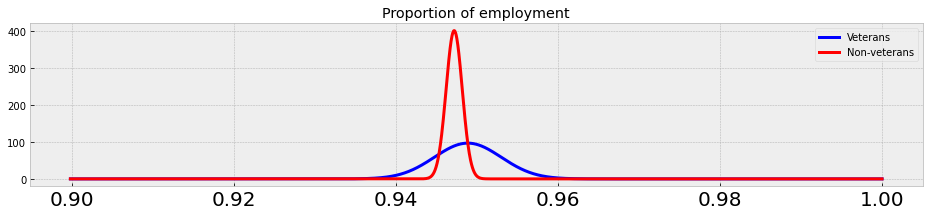

In [55]:
m = NILF_pdf[NILF_pdf['Vet Status'] == 'Veterans']['Population'].values[0]
n = NILF_pdf[NILF_pdf['Vet Status'] == 'Civilians']['Population'].values[0]
X = NILF_pdf[NILF_pdf['Vet Status'] == 'Veterans']['Working'].values[0]
Y = NILF_pdf[NILF_pdf['Vet Status'] == 'Civilians']['Working'].values[0]

savetofile = 'NILF_proportions'
title = "Proportion of employment"
plot_workforce_proportions(m, X, n, Y, title, savetofile)

('diff in proportion: 0.0017, total proportion: 0.947, variance: 0.00002, p_value: 0.654, z_alpha: -0.008',
 'Proportions - Sample 1: 0.949; Sample 2: 0.947. Difference: 0.002',
 'The p-value is: 0.654, and the rejection thresholds are -0.008 and 0.008',
 "For 'H_0 : p_1 = p_2', the test rejects the null hypothesis")

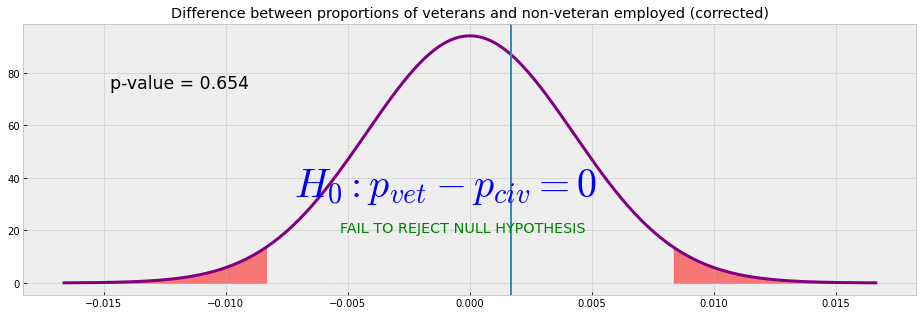

In [56]:
title = 'Difference between proportions of veterans and non-veteran employed (corrected)'
savetofile = 'nilf_diff'
plot_test_results(m, X, n, Y, title, savetofile, null_hypothesis)

test_report(m, X, n, Y)

---

# EDUCATION

In [39]:
query = '''SELECT
    AgeGroup,
    COUNT(*) as Pop,
    SUM(CASE WHEN (PEEDUCA < 39) THEN 1 ELSE 0 END) AS lt_HS,
    round(100 * SUM(CASE WHEN (PEEDUCA < 39) THEN 1 ELSE 0 END) / COUNT(*), 1) as lt_HS_pct,
    SUM(CASE WHEN (PEEDUCA = 39 or PEEDUCA = 40) THEN 1 ELSE 0 END) AS HS_Grad,
    round(100 * SUM(CASE WHEN (PEEDUCA = 39 or PEEDUCA = 40) THEN 1 ELSE 0 END) / COUNT(*), 1) as HS_pct,
    SUM(CASE WHEN (PEEDUCA = 41 or PEEDUCA = 42) THEN 1 ELSE 0 END) AS AA,
    round(100 * SUM(CASE WHEN (PEEDUCA = 41 or PEEDUCA = 42) THEN 1 ELSE 0 END) / COUNT(*), 1) as AA_pct,
    SUM(CASE WHEN (PEEDUCA = 43) THEN 1 ELSE 0 END) AS Bachelors,
    round(100 * SUM(CASE WHEN (PEEDUCA = 43) THEN 1 ELSE 0 END) / COUNT(*), 1) as Bach_pct,
    SUM(CASE WHEN (PEEDUCA = 44) THEN 1 ELSE 0 END) AS Masters,
    round(100 * SUM(CASE WHEN (PEEDUCA = 44) THEN 1 ELSE 0 END) / COUNT(*), 1) as M_pct,
    SUM(CASE WHEN (PEEDUCA = 45) THEN 1 ELSE 0 END) AS Professional,
    round(100 * SUM(CASE WHEN (PEEDUCA = 45) THEN 1 ELSE 0 END) / COUNT(*), 1) as Prof_pct,
    SUM(CASE WHEN (PEEDUCA = 46) THEN 1 ELSE 0 END) AS Doctorate,
    round(100 * SUM(CASE WHEN (PEEDUCA = 46) THEN 1 ELSE 0 END) / COUNT(*), 1) as Doc_pct
FROM
    apr21_df
WHERE 
    AgeGroup != '  None'
GROUP BY
    AgeGroup
ORDER BY
    AgeGroup
'''

ed_pdf = spark.sql(query).toPandas()

<AxesSubplot:xlabel='Age Categories', ylabel='Population'>

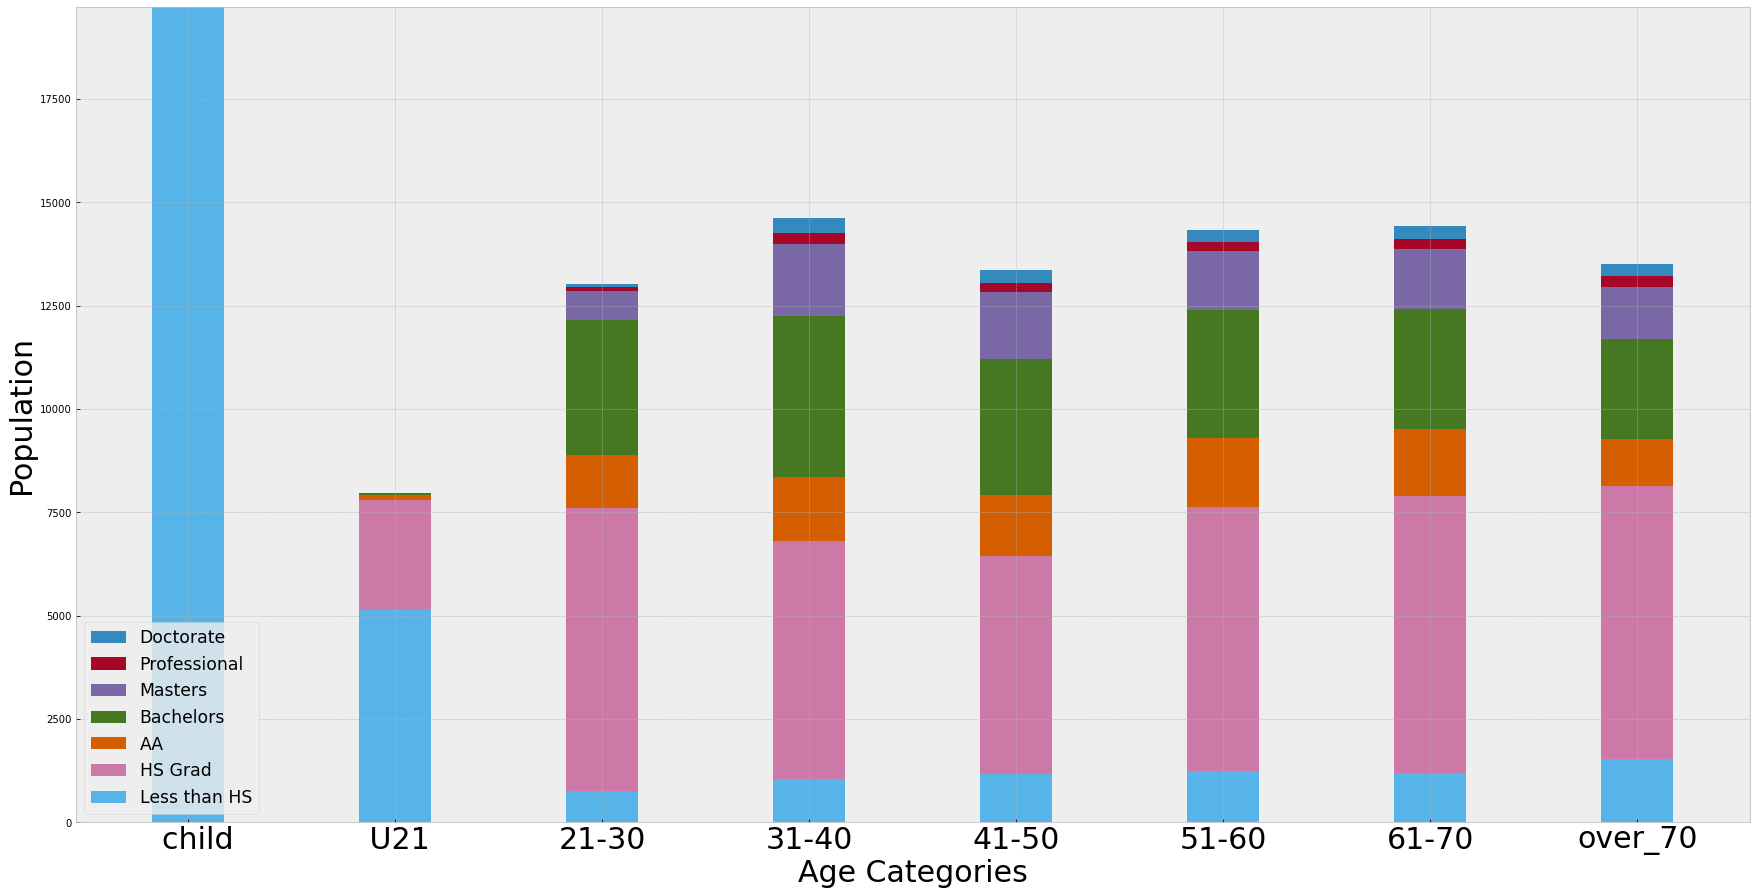

In [40]:
plot_edu(ed_pdf)


<AxesSubplot:title={'center':'Educational Degrees'}, ylabel='Population'>

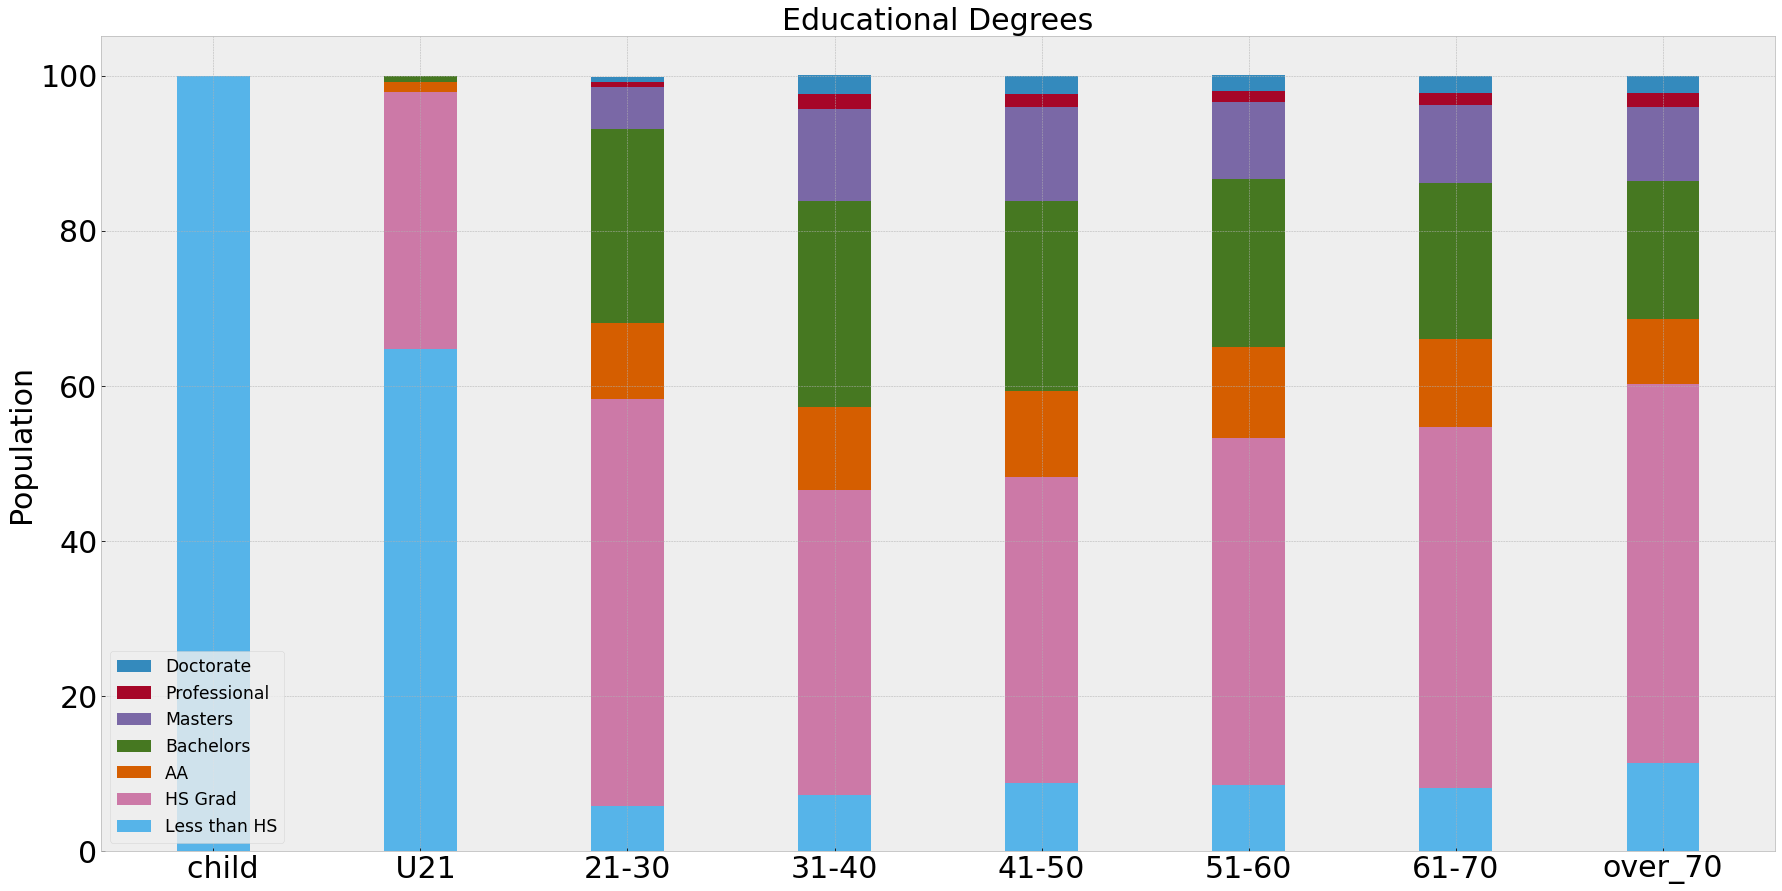

In [41]:
plot_edu_pct(ed_pdf)

# Education and Income

Does education affect income? 

$H_0$: Income with an advanced degree is higher than income without an advanced degree.

In [ ]:
query = '''SELECT 
    HRHHID ,
    HEFAMINC , 
    HHincome ,
    PEEDUCA ,
    (CASE WHEN PEEDUCA > 43 THEN 1 ELSE 0 END) AS ADV_DEG
FROM
    apr21_df
WHERE 
    PEMLR = 1
'''

inc_pdf = spark.sql(query).toPandas()
inc_pdf

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 3))

ax.hist( inc_pdf[inc_pdf['ADV_DEG'] == 0]['HHincome'], color='b', label='No Advance Degree')
ax.hist( inc_pdf[inc_pdf['ADV_DEG'] == 1]['HHincome'], color='r', label='Advance Degree')
ax.set_title("Distribution of Household Income")
ax.axvline(inc_pdf[inc_pdf['ADV_DEG'] == 0]['HHincome'].median(), color='b')
ax.axvline(inc_pdf[inc_pdf['ADV_DEG'] == 1]['HHincome'].median(), color='r')
ax.legend()

In [ ]:
query = '''SELECT
    ADV_DEG ,
    COUNT(*) as Pop,
    ROUND(AVG(HHincome)) AS AVG_INCOME
FROM
    (SELECT 
    HRHHID ,
    HHincome , 
    (CASE WHEN PEEDUCA > 43 THEN 1 ELSE 0 END) AS ADV_DEG
FROM
    apr21_df
WHERE 
    PEMLR = 1)
GROUP BY
    ADV_DEG
'''

tmp_pdf = spark.sql(query).toPandas()
tmp_pdf

In [ ]:
n = inc_pdf['HHincome'].count()
n_0 = inc_pdf[inc_pdf['ADV_DEG'] == 0]['HHincome'].count()
n_1 = inc_pdf[inc_pdf['ADV_DEG'] == 1]['HHincome'].count()
se_0 = inc_pdf[inc_pdf['ADV_DEG'] == 0]['HHincome'].std()
se_1 = inc_pdf[inc_pdf['ADV_DEG'] == 1]['HHincome'].std()
mu_0 = inc_pdf[inc_pdf['ADV_DEG'] == 0]['HHincome'].mean()
mu_1 = inc_pdf[inc_pdf['ADV_DEG'] == 1]['HHincome'].mean()

In [ ]:
pdf_0 = inc_pdf[inc_pdf['ADV_DEG'] == 0]['HHincome']
pdf_1 = inc_pdf[inc_pdf['ADV_DEG'] == 1]['HHincome']

test_statistic, pvalue = stats.ttest_ind(pdf_0, pdf_1, equal_var = False)
dof = welch_satterhwaithe_dof(pdf_0, pdf_1)
test_statistic, pvalue, dof

In [ ]:
x = np.linspace(-3, 3, num=250)

fig, ax = plt.subplots(1, figsize=(16, 3))
students = stats.t(dof)
ax.plot(x, students.pdf(x), linewidth=2, label="Degree of Freedom: {:2.2f}".format(dof))
_ = ax.fill_between(x, students.pdf(x), where=(x >= -test_statistic), color="blue", alpha=0.25)
_ = ax.fill_between(x, students.pdf(x), where=(x <= test_statistic), color="red", alpha=0.25)
ax.axvline(test_statistic)
ax.legend()
ax.set_title("p-value Region")

In [ ]:
inc_pdf[['HEFAMINC','PEEDUCA']]


In [ ]:
query = '''SELECT 
    HRHHID ,
    HURESPLI , 
    HUFINAL ,
    HRMIS ,
    HRHHID2 ,
    HWHHWTLN
FROM
    apr21_df
'''

tmp_pdf = spark.sql(query).toPandas()
tmp_pdf